In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import keras.backend as K
from keras import regularizers
import keras_tuner as kt
from keras.utils.vis_utils import plot_model
from multi_label_metrics import *
from sklearn.calibration import calibration_curve
from BM import bm_counter
import tensorflow_probability as tfp
from sklearn.isotonic import IsotonicRegression
from stellargraph.calibration import TemperatureCalibration, IsotonicCalibration
from stellargraph.calibration import plot_reliability_diagram, expected_calibration_error
from calibration_module.calibrator import (
    HistogramCalibrator,
    PlattCalibrator,
    PlattHistogramCalibrator
)
from label_info import label_counter

In [2]:
from numpy.random import seed
seed(11)
from tensorflow.random import set_seed
set_seed(22)
data,_ = arff.loadarff(r'./dataset/emotions.arff')
df = pd.DataFrame(data) 
df=df.sample(frac=1,random_state = 1) #shuffle the data
rows,cols = df.shape
df.head()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
518,0.109158,0.268949,0.076101,-60.018661,3.404251,0.610929,1.294005,-0.032829,0.707993,-0.214837,...,2.0,0.130155,0.474332,1.487590,b'1',b'0',b'0',b'0',b'0',b'1'
347,0.097436,0.251339,0.080042,-63.662213,3.899974,0.230644,1.252723,0.676819,0.076229,0.327339,...,2.0,0.278332,0.116057,0.829020,b'1',b'0',b'0',b'0',b'0',b'0'
395,0.063232,0.140621,0.082097,-66.596131,5.594724,0.350716,1.023655,0.439544,0.855564,0.414784,...,2.0,1.788567,0.032760,3.076057,b'0',b'0',b'0',b'0',b'1',b'0'
498,0.045979,0.285937,0.088668,-73.201192,4.868248,1.720746,1.374652,0.617047,0.522640,0.714393,...,3.0,0.213425,0.207252,0.929706,b'0',b'1',b'1',b'0',b'0',b'0'
460,0.027327,0.051877,0.083688,-76.692269,8.859399,0.366078,2.011369,1.104186,1.384590,0.231731,...,2.0,0.107568,0.301729,0.780669,b'0',b'0',b'1',b'1',b'1',b'0'


In [3]:
split_index = int(rows * 0.8)
data_train:pd.DataFrame = df.iloc[:split_index,:]
data_test:pd.DataFrame = df.iloc[split_index:,:]
x_train = np.array(data_train.iloc[:,:-6].values,dtype ='float32')
y_train = np.array(data_train.iloc[:,-6:].values,dtype ='int')
x_test = np.array(data_test.iloc[:,:-6].values,dtype ='float32')
y_test = np.array(data_test.iloc[:,-6:].values,dtype ='int')

X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))
label_info = label_counter(X,Y)

for l in range(len(label_info)):
    print("Number of instances with %s positive label(s): %s" %(l,label_info[l].astype("int32")))



Number of instances with 0 positive label(s): 0
Number of instances with 1 positive label(s): 178
Number of instances with 2 positive label(s): 315
Number of instances with 3 positive label(s): 100
Number of instances with 4 positive label(s): 0
Number of instances with 5 positive label(s): 0
Number of instances with 6 positive label(s): 0


In [4]:
from keras.layers import Input,Dense
input_dim = cols-6
output_dim = 6
def build_model(hp):
    #hp = hyperparamters to be modified
    model = Sequential()
    model.add(Dense(hp.Int('units_1',min_value = 80,max_value = 120,step=10),input_dim=input_dim,activation='relu'))
    model.add(Dense(hp.Int('units_2',min_value = 60,max_value = 90,step=10),activation='relu'))
    model.add(Dense(hp.Int('units_3',min_value=40,max_value=70,step=10),activation='relu'))
    model.add(Dense(hp.Int('units_4',min_value=20,max_value=50,step=10),activation='relu'))
    model.add(Dense(hp.Int('units_5',min_value=20,max_value=50,step=10),activation='relu'))
    model.add(Dense(output_dim,activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['binary_accuracy',hamming_loss,precision_micro,recall_micro,f1_micro])
    return model

In [5]:
#Build Tuner 
tuner = kt.RandomSearch(
    build_model,
    kt.Objective("hamming_loss", direction="min"), #optimization objective is binary accuracy, for fault diagnosis can also be recall rate
    max_trials = 20,
    executions_per_trial = 1,
    overwrite = True,
    project_name="Emotion_Tuner")

Trial 20 Complete [00h 00m 34s]
hamming_loss: 0.22677293419837952

Best hamming_loss So Far: 0.09878405928611755
Total elapsed time: 00h 10m 22s
INFO:tensorflow:Oracle triggered exit


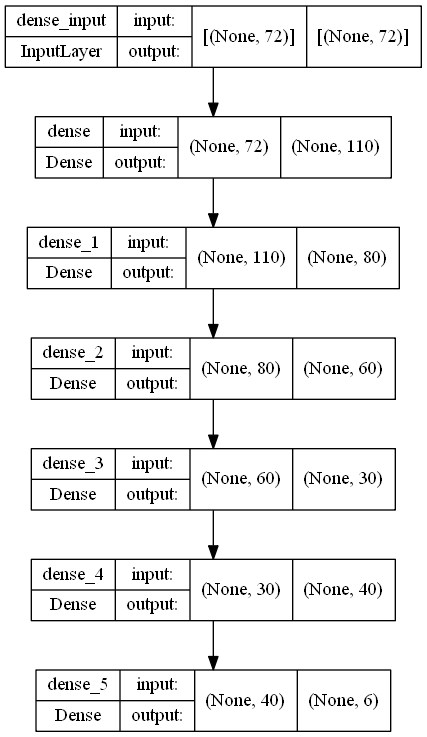

In [6]:
#get the best model with tuner
callback = tf.keras.callbacks.EarlyStopping(monitor='val_hamming_loss', patience=20)
tuner.search(x_train,y_train,epochs=500,batch_size=256,validation_split=0.25,shuffle=True,verbose=1)
best_model = tuner.get_best_models()[0]
plot_model(best_model, to_file='./best_model_emotion.png', show_shapes=True)

In [7]:
#evaluate the best_model with test data
loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro = best_model.evaluate(x_test, y_test)
print('Test:')
print('Loss: %s\nBinary-Accuracy(the same as Micro-Accuracy): %s \nHamming_Loss: %s \nMicro-Precision: %s \nMicro-Recall: %s \nMicro-F1 Score: %s' % (loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro))

4/4 [==============================] - 0s 2ms/step - loss: 0.6776 - binary_accuracy: 0.7717 - hamming_loss: 0.2296 - precision_micro: 0.6487 - recall_micro: 0.5982 - f1_micro: 0.6212
Test:
Loss: 0.6776496171951294
Binary-Accuracy(the same as Micro-Accuracy): 0.7717086672782898 
Hamming_Loss: 0.22956295311450958 
Micro-Precision: 0.6486933827400208 
Micro-Recall: 0.5981519222259521 
Micro-F1 Score: 0.6212217807769775


In [8]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 110)               8030      
                                                                 
 dense_1 (Dense)             (None, 80)                8880      
                                                                 
 dense_2 (Dense)             (None, 60)                4860      
                                                                 
 dense_3 (Dense)             (None, 30)                1830      
                                                                 
 dense_4 (Dense)             (None, 40)                1240      
                                                                 
 dense_5 (Dense)             (None, 6)                 246       
                                                                 
Total params: 25,086
Trainable params: 25,086
Non-traina

In [9]:
y_pred = best_model.predict(x_test) 
predictions = (y_pred > 0.5).astype("int32")

In [10]:
recall_macro(y_test,predictions)

(array([0.25      , 0.37931034, 0.80357143, 0.8125    , 0.54545455,
        0.65      ]),
 0.5734727198089267)

In [11]:
precision_macro(y_test,predictions)


(array([0.69230769, 0.36666667, 0.63380282, 0.78787879, 0.64285714,
        0.8125    ]),
 0.656002184435283)

In [12]:
f1_macro(y_test,predictions)

(array([0.36734694, 0.37288136, 0.70866142, 0.8       , 0.59016393,
        0.72222222]),
 0.5935459781131668)

In [13]:
accuracy_each_label(y_test,predictions)

array([0.7394958 , 0.68907563, 0.68907563, 0.8907563 , 0.78991597,
       0.83193277])

In [14]:
np.mean(accuracy_each_label(y_test,predictions))

0.7717086834733893

In [15]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_pred)

0.6313494263016713

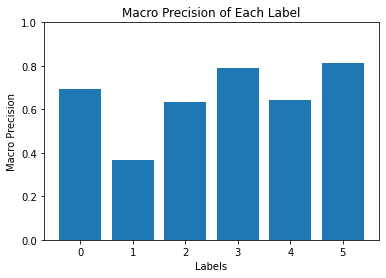

In [16]:
plt.bar(range(6),precision_macro(y_test,predictions)[0])
plt.ylim((0, 1))
plt.title('Macro Precision of Each Label')
plt.ylabel('Macro Precision')
plt.xlabel('Labels')
plt.savefig("./emotion_macro_precision.jpg" )

In [17]:
#calibration 
data_val:pd.DataFrame = data_train.iloc[:int(split_index*1),:] #all the train data used for isotonic, logic described by Zadro, 
x_val = np.array(data_val.iloc[:,:-6].values,dtype ='float32')
y_val = np.array(data_val.iloc[:,-6:].values,dtype ='int')
y_val_pred = (best_model.predict(x_val))

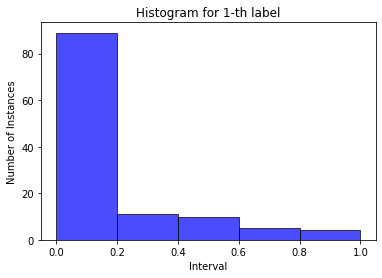

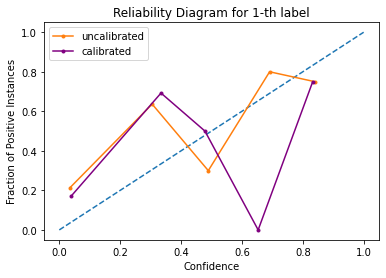

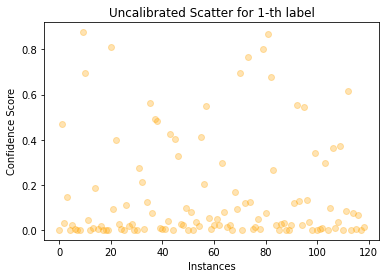

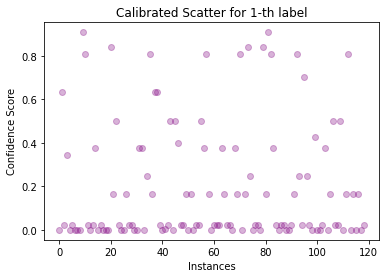

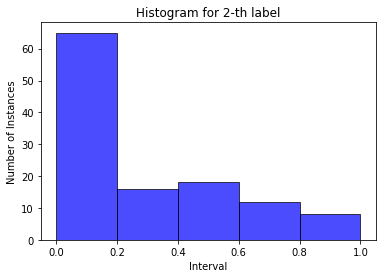

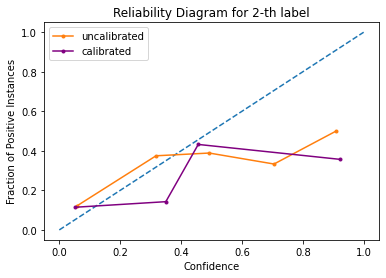

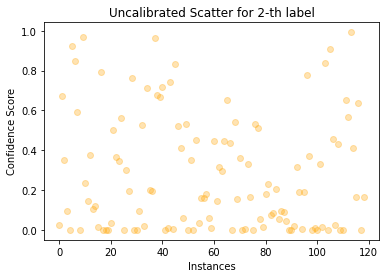

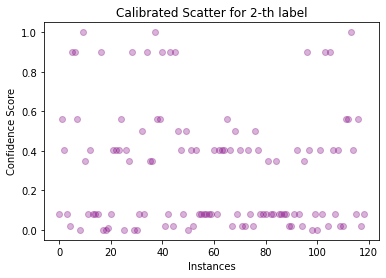

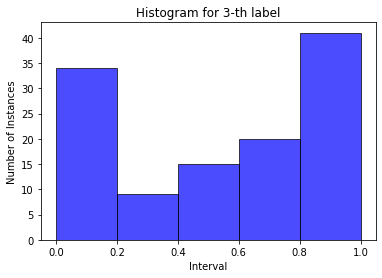

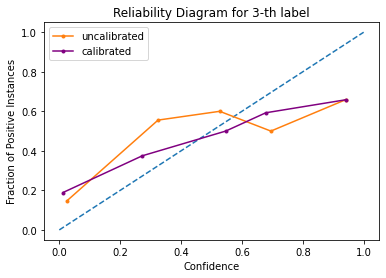

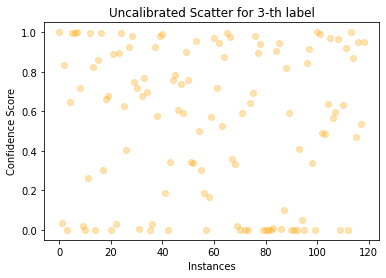

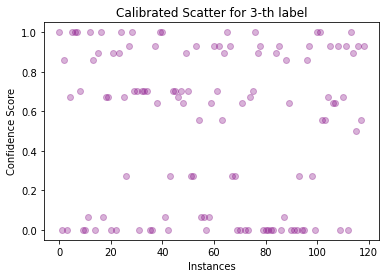

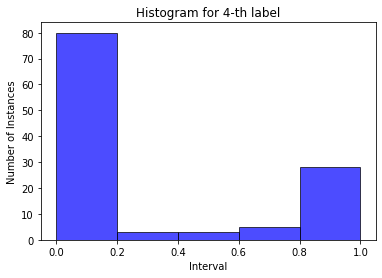

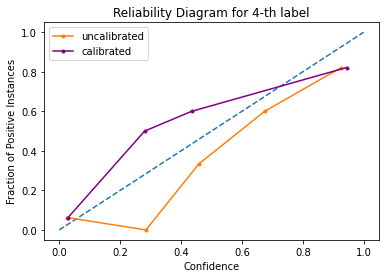

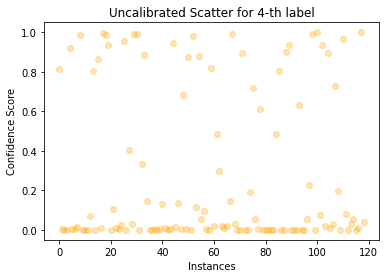

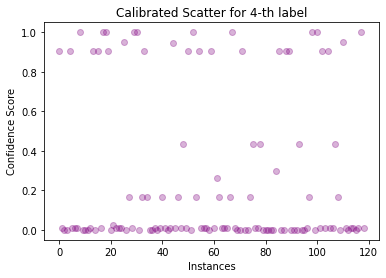

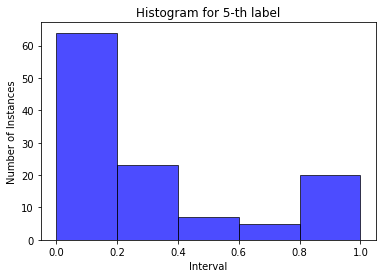

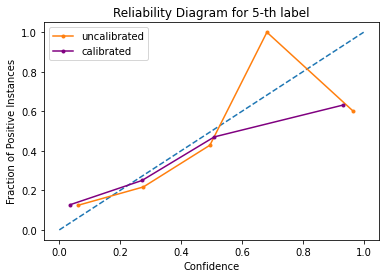

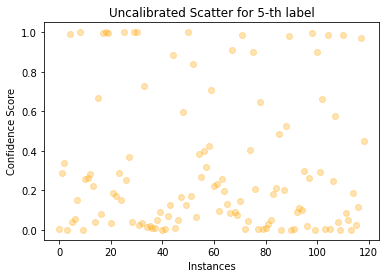

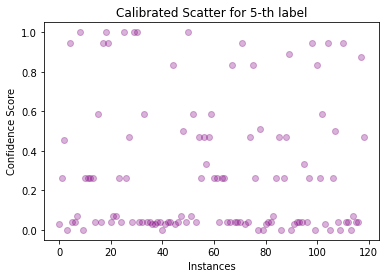

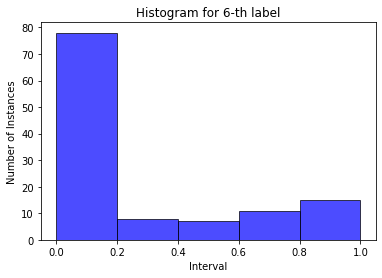

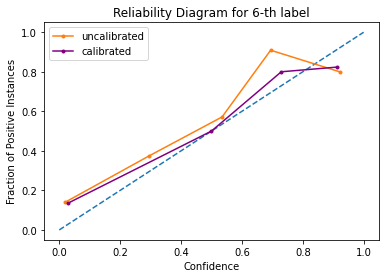

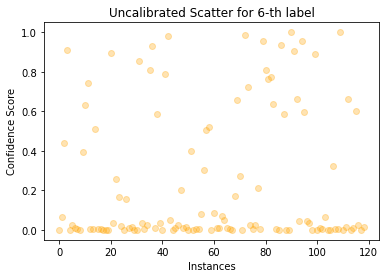

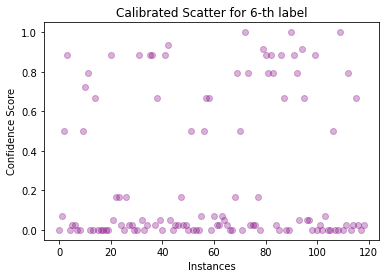

Expected Calibration Error for each label = [0.18760606587419543, 0.12314847053899988, 0.19154308655220306, 0.06232874566486146, 0.12375525089957606, 0.12167767746754977]
Expected Calibration Error for each label after Calibration = [0.16177381764502585, 0.11764948173355655, 0.18131698229733637, 0.062494191982853824, 0.1059908134972348, 0.09391386717745738]
Average Expected Calibration Error for all labels = 0.1350098828328976
Average Expected Calibration Error for all labels after Calibration = 0.1205231923889108


In [18]:
#Histograms of predictive value and reliability diagrams to show non-calibration 
ECE=[]
ECE_cal = []
calibrated_predictions =[]
bins =5
for i in range(np.shape(y_test)[1]):
    #val set for isotonic and train the isotonic model 
    ir = IsotonicRegression(out_of_bounds='clip',y_min=0,y_max=1)
    prob_val_true,prob_val_pred = calibration_curve(y_val[:,i],y_val_pred[:,i],n_bins=bins)
    ir.fit(y_val_pred[:,i],y_val[:,i])
    
    #histogram
    plt.hist(y_pred[:,i],bins = bins,range=(0,1),facecolor="blue", edgecolor="black", alpha=0.7)
    plt.title('Histogram for %s-th label' %(i+1))
    plt.ylabel('Number of Instances')
    plt.xlabel('Interval')
    plt.savefig("./emotion_hist_%s.jpg" %(i+1))
    plt.show()
    
    #reliability diagram
    prob_true, prob_pred = calibration_curve(y_test[:,i], y_pred[:,i], n_bins=bins) #acc for each bin, avg pred for each bin 
    Bm = bm_counter(y_pred[:,i],bins)
    Bm = Bm[Bm != 0]
    temp_ece=np.sum(abs(prob_pred - prob_true)*Bm)/np.shape(y_pred)[0]
    ECE.append(temp_ece)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(prob_pred, prob_true, marker='.',label = 'uncalibrated')
    
    #calibration with isotonic regression
    
    #iso for each label
    y_pred_cal = np.array(ir.predict(y_pred[:,i]),dtype="float32")
    calibrated_predictions.append((y_pred_cal>0.5).astype("int32"))
    prob_true_cal, prob_pred_cal = calibration_curve(y_test[:,i],y_pred_cal, n_bins = bins)
    Bm_cal = bm_counter(y_pred_cal,bins)
    Bm_cal = Bm_cal[Bm_cal!=0]
    temp_ece_cal=np.sum(abs(prob_pred_cal - prob_true_cal)*Bm_cal)/np.shape(y_pred_cal)[0]
    ECE_cal.append(temp_ece_cal)
    plt.plot(prob_pred_cal,prob_true_cal, marker='.',color = "purple", label='calibrated')
    plt.title('Reliability Diagram for %s-th label' %(i+1))
    plt.ylabel('Fraction of Positive Instances')
    plt.xlabel('Confidence')
    plt.legend()
    plt.savefig("./emotion_rd_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
    
    #comparison of scatter before and after calibration
    plt.scatter(range(np.shape(y_pred)[0]),y_pred[:,i],color = "orange",label = ' uncalibrated',alpha= 0.3)
    plt.title('Uncalibrated Scatter for %s-th label' %(i+1))
    plt.ylabel('Confidence Score')
    plt.xlabel('Instances')
    plt.savefig("./emotion_scatter_uncal_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
    
    plt.scatter(range(np.shape(y_pred_cal)[0]),y_pred_cal,color = "purple",label = 'calibrated',alpha = 0.3)
    plt.title('Calibrated Scatter for %s-th label' %(i+1))
    plt.ylabel('Confidence Score')
    plt.xlabel('Instances')
    plt.savefig("./emotion_scatter_cal_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
calibrated_predictions = np.array(calibrated_predictions).T
print('Expected Calibration Error for each label = %s' %ECE)
print('Expected Calibration Error for each label after Calibration = %s' %ECE_cal)
avg_ECE = np.mean(ECE)
avg_ECE_cal= np.mean(ECE_cal)
print('Average Expected Calibration Error for all labels = %s' %avg_ECE)
print('Average Expected Calibration Error for all labels after Calibration = %s' %avg_ECE_cal)

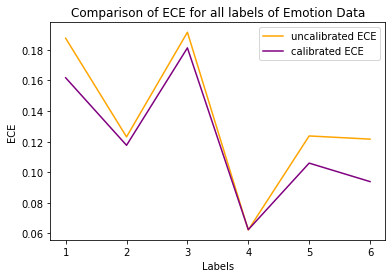

Uncalibrated Model macro metrics: 
 Recall: (array([0.25      , 0.37931034, 0.80357143, 0.8125    , 0.54545455,
       0.65      ]), 0.5734727198089267) 
 Precision: (array([0.69230769, 0.36666667, 0.63380282, 0.78787879, 0.64285714,
       0.8125    ]), 0.656002184435283) 
 F1: (array([0.36734694, 0.37288136, 0.70866142, 0.8       , 0.59016393,
       0.72222222]), 0.5935459781131668) 
 Accuracy:[0.7394958  0.68907563 0.68907563 0.8907563  0.78991597 0.83193277] 

 ------------------------------------
Calibrated Model macro metrics:
 Recall: (array([0.25      , 0.27586207, 0.82142857, 0.71875   , 0.51515152,
       0.65      ]), 0.5385320259242673) 
 Precision: (array([0.5625    , 0.34782609, 0.63013699, 0.82142857, 0.68      ,
       0.8125    ]), 0.6423986074477439) 
 F1: (array([0.34615385, 0.30769231, 0.71317829, 0.76666667, 0.5862069 ,
       0.72222222]), 0.5736867056434017) 
 Accuracy:[0.71428571 0.69747899 0.68907563 0.88235294 0.79831933 0.83193277] 



In [19]:
#calibrated model for test data evaluation Macro
plt.plot([1,2,3,4,5,6],ECE, label='uncalibrated ECE',color = "orange")
plt.plot([1,2,3,4,5,6],ECE_cal,color = "purple",label = 'calibrated ECE')
plt.title('Comparison of ECE for all labels of Emotion Data')
plt.ylabel('ECE')
plt.xlabel('Labels')
plt.legend()
plt.savefig("./emotion_ece_comparison.jpg" )
plt.show()
print("Uncalibrated Model macro metrics: \n Recall: %s \n Precision: %s \n F1: %s \n Accuracy:%s \n" 
      %(recall_macro(y_test,predictions),precision_macro(y_test,predictions),
      f1_macro(y_test,predictions),accuracy_each_label(y_test,predictions))+"\n ------------------------------------")
print("Calibrated Model macro metrics:\n Recall: %s \n Precision: %s \n F1: %s \n Accuracy:%s \n"
      %(recall_macro(y_test,calibrated_predictions),precision_macro(y_test,calibrated_predictions),
      f1_macro(y_test,calibrated_predictions),accuracy_each_label(y_test,calibrated_predictions)))